# Deriving Potentials for Coarse-Grained Nanoparticles

Here, we move beyond the simple point-particle system.  Our system will now contain two coarse-grained nanoparticles, constructed as a spherical shell of coarse-grained beads, or child particles.  To define our forcefield, we need to derive the interaction between two of these coarse-grained beads.  This is achieved by matching the interaction potential between two coarse-grained nanoparticles to the potential between two all-atom nanoparticles.

In [1]:
from nanoparticle_optimization import AA_nano

aa_nano = AA_nano(radius=4)
aa_nano.visualize()

/Users/summeraz/src/github/mosdef-hub/mbuild/mbuild/compound.py:2183: UserWarning: Guessing that "<SI pos=( 4.8542, 4.3209, 1.8580), 0 bonds, id: 112315547208>" is element: "S"
  atom, element))


NGLWidget()

Text(0,0.5,'U, kcal/mol')

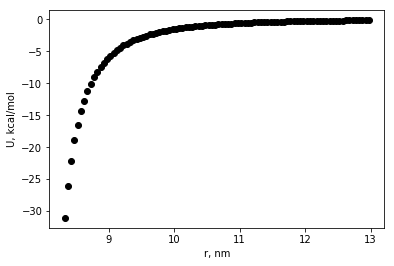

In [2]:
import pkg_resources

import numpy as np

import nanoparticle_optimization
from nanoparticle_optimization.target import load

resource_package = nanoparticle_optimization.__name__
resource_path = '/'.join(('utils', 'target_data', 'np_np', 'truncated', 'U_4nm_truncated.txt'))
target_4 = load(pkg_resources.resource_filename(resource_package, resource_path))

target_4.separations /= 10.0

import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(target_4.separations, target_4.potential, linestyle='None', marker='o', color='black')
plt.xlabel('r, nm')
plt.ylabel('U, kcal/mol')

Text(0,0.5,'U, kcal/mol')

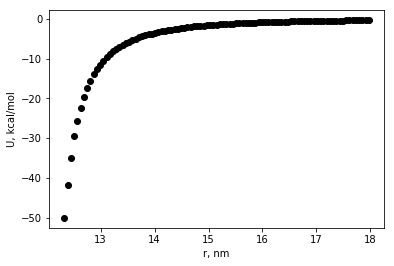

In [3]:
import pkg_resources

import numpy as np

import nanoparticle_optimization
from nanoparticle_optimization.target import load

resource_package = nanoparticle_optimization.__name__
resource_path = '/'.join(('utils', 'target_data', 'np_np', 'truncated', 'U_6nm_truncated.txt'))
target_6 = load(pkg_resources.resource_filename(resource_package, resource_path))

target_6.separations /= 10.0

import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(target_6.separations, target_6.potential, linestyle='None', marker='o', color='black')
plt.xlabel('r, nm')
plt.ylabel('U, kcal/mol')

In [4]:
from nanoparticle_optimization import CG_nano

cgnano_4 = CG_nano(radius=4.0, bead_diameter=0.8, bvf=0.5)
cgnano_4.visualize()

/Users/summeraz/src/github/mosdef-hub/mbuild/mbuild/compound.py:2183: UserWarning: Guessing that "<_CGN pos=( 0.3257, 0.0000,-3.7876), 0 bonds, id: 112119416536>" is element: "EP"
  atom, element))


NGLWidget()

In [5]:
cgnano_6 = CG_nano(radius=6.0, bead_diameter=0.8, bvf=0.5)

The coarse-grained nanoparticle is constructed as a hollow sphere of pseudo-atoms.  We have created a nanoparticle with a radius of 3nm (to match our atomistic model) and a `sigma` of 0.8nm.  `Sigma` defines the radius of the pseudo-atoms and also corresponds to the `sigma` in the Mie forcefield defining their interactions.  Thus, larger values of `sigma` can be used to create a more coarse-grained nanoparticle.

In [6]:
from nanoparticle_optimization.forcefield import Mie, Parameter
from nanoparticle_optimization.system import System

sigma = Parameter(value=0.8, fixed=True)
epsilon = Parameter(value=6.0, upper=20.0, lower=0.1)
n = Parameter(value=35.0, fixed=True)
m = Parameter(value=5.0, upper=20.0, lower=3.0)
ff = Mie(sigma=sigma, epsilon=epsilon, n=n, m=m)

system_4 = System(cgnano_4)
system_6 = System(cgnano_6)

We hold `sigma` fixed to the radius of the psuedo-atoms and allow `epsilon`, `n`, and `m` to be optimized.

In [7]:
from nanoparticle_optimization.optimization import Optimization

optimization = Optimization(forcefield=ff, systems=[system_4, system_6], targets=[target_4, target_6],
                                   configurations=10)
optimization.optimize(brute_force=True, gridpoints=8, verbose=True,
                      r_dependent_sampling=True, maxiter=50, polishing_function=None)

epsilon: 0.1

m: 3.0

Residual: 0.9816628685320625


epsilon: 0.1

m: 3.0

Residual: 0.9817689686442554


epsilon: 0.1

m: 5.428571428571429

Residual: 1.784676324324638


epsilon: 0.1

m: 7.857142857142857

Residual: 1.9588403276430726


epsilon: 0.1

m: 10.285714285714285

Residual: 1.9829824184551414


epsilon: 0.1

m: 12.714285714285714

Residual: 1.9896814580794595


epsilon: 0.1

m: 15.142857142857142

Residual: 1.995293424501397


epsilon: 0.1

m: 17.57142857142857

Residual: 1.9949538292476823


epsilon: 0.1

m: 20.0

Residual: 1.997269733908424


epsilon: 2.9428571428571426

m: 3.0

Residual: 1.9495751068679537


epsilon: 2.9428571428571426

m: 5.428571428571429

Residual: 0.5014350744375933


epsilon: 2.9428571428571426

m: 7.857142857142857

Residual: 1.0908539141865665


epsilon: 2.9428571428571426

m: 10.285714285714285

Residual: 1.5823244392874818


epsilon: 2.9428571428571426

m: 12.714285714285714

Residual: 1.7793643185754713


epsilon: 2.9428571428571426

m: 15.14285

In [8]:
grid_residuals = optimization.grid_residuals
epsilon_vals = optimization.grid[0]
m_vals = optimization.grid[1]
minimum = np.array(np.unravel_index(grid_residuals.argmin(), grid_residuals.shape))
epsilon_at_min = epsilon_vals[minimum[0]][0]
m_at_min = m_vals[0][minimum[1]]

# Set new bounds
try:
    emax = epsilon_vals[tuple(minimum + np.array([2, 0]))]
except IndexError:
    emax = epsilon_vals[-1, 0]
if minimum[0] - 2 >= 0:
    emin = epsilon_vals[tuple(minimum + np.array([-2, 0]))]
else:
    emin = epsilon_vals[0, 0]
    
try:
    mmax = m_vals[tuple(minimum + np.array([0, 2]))]
except IndexError:
    mmax = m_vals[0, -1]
if minimum[1] - 2 >= 0:
    mmin = m_vals[tuple(minimum + np.array([0, -2]))]
else:
    mmin = m_vals[0, 0]

print('Emax: {:.3f},\tEmin: {:.3f}'.format(emax, emin))
print('m-max: {:.3f},\tm-min: {:.3f}'.format(mmax, mmin))

Emax: 8.629,	Emin: 0.100
m-max: 10.286,	m-min: 3.000


In [10]:
sigma = Parameter(value=0.8, fixed=True)
epsilon = Parameter(value=6.0, upper=emax, lower=emin)
n = Parameter(value=35.0, fixed=True)
m = Parameter(value=5.0, upper=mmax, lower=mmin)
ff = Mie(sigma=sigma, epsilon=epsilon, n=n, m=m)

cgnano_4 = CG_nano(radius=4.0, bead_diameter=0.8, bvf=0.5)
cgnano_6 = CG_nano(radius=6.0, bead_diameter=0.8, bvf=0.5)
system_4 = System(cgnano_4)
system_6 = System(cgnano_6)
optimization = Optimization(forcefield=ff, systems=[system_4, system_6], targets=[target_4, target_6],
                                   configurations=10)
optimization.optimize(brute_force=True, gridpoints=8, verbose=True,
                      r_dependent_sampling=True, maxiter=50)

epsilon: 0.1

m: 3.0

Residual: 0.9816628685320625


epsilon: 0.1

m: 3.0

Residual: 0.9817689686442554


epsilon: 0.1

m: 4.040816326530612

Residual: 0.9403144079246623


epsilon: 0.1

m: 5.081632653061224

Residual: 1.6914977564883555


epsilon: 0.1

m: 6.122448979591836

Residual: 1.8815333706886408


epsilon: 0.1

m: 7.163265306122448

Residual: 1.939282126336081


epsilon: 0.1

m: 8.204081632653061

Residual: 1.9647809798052334


epsilon: 0.1

m: 9.244897959183673

Residual: 1.9748073548891778


epsilon: 0.1

m: 10.285714285714285

Residual: 1.984664696390644


epsilon: 1.3183673469387756

m: 3.0

Residual: 1.8891852518693772


epsilon: 1.3183673469387756

m: 4.040816326530612

Residual: 1.3129207008428017


epsilon: 1.3183673469387756

m: 5.081632653061224

Residual: 0.11734546429945436


epsilon: 1.3183673469387756

m: 6.122448979591836

Residual: 0.859810486555652


epsilon: 1.3183673469387756

m: 7.163265306122448

Residual: 1.3644329483985569


epsilon: 1.3183673469387756

m

epsilon: 1.3220084676937187

m: 5.152689906529018

Residual: 0.08891094820663603


epsilon: 1.3223461766145672

m: 5.152761630622708

Residual: 0.08404821055568949


epsilon: 1.322178202259298

m: 5.152536765896544

Residual: 0.07950001023639353


epsilon: 1.3224319240025115

m: 5.152496057627152

Residual: 0.08041886719932109


epsilon: 1.3224104871555253

m: 5.152562450876041

Residual: 0.09416915071095305


epsilon: 1.3223890503085394

m: 5.15262884412493

Residual: 0.08297608549259143


epsilon: 1.3224730374861742

m: 5.152741276488012

Residual: 0.08086808926259276


epsilon: 1.3226838855354157

m: 5.152833354716396

Residual: 0.09059061901634638


epsilon: 1.3224627591152585

m: 5.1526799717727965

Residual: 0.09596336929913118


epsilon: 1.3225364679219775

m: 5.152731099420663

Residual: 0.08187350029221115


epsilon: 1.3224944743331601

m: 5.152674883239122

Residual: 0.08319056039121253


epsilon: 1.3226418919465983

m: 5.152777138534855

Residual: 0.08276180612498556


epsil

Text(0,0.5,'U, kcal/mol')

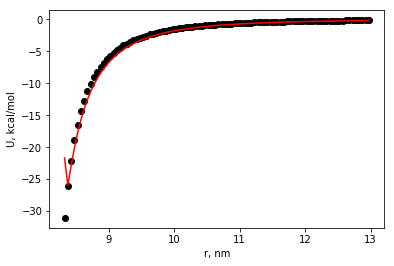

In [12]:
U_opt_4, _ = zip(*system_4.calc_potential(forcefield=optimization.forcefield, separations=target_4.separations))

plt.plot(target_4.separations, target_4.potential, linestyle='None', marker='o', color='black')
plt.plot(target_4.separations, U_opt_4, marker='None', color='red')
plt.xlabel('r, nm')
plt.ylabel('U, kcal/mol')

Text(0,0.5,'U, kcal/mol')

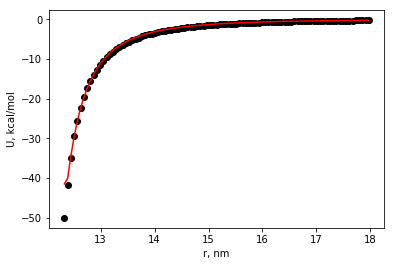

In [13]:
U_opt_6, _ = zip(*system_6.calc_potential(forcefield=optimization.forcefield, separations=target_6.separations))

plt.plot(target_6.separations, target_6.potential, linestyle='None', marker='o', color='black')
plt.plot(target_6.separations, U_opt_6, marker='None', color='red')
plt.xlabel('r, nm')
plt.ylabel('U, kcal/mol')

The optimized potential between the pseudo-atoms leads to a nanoparticle-nanoparticle interaction potential that closely matches the all-atom target data, with a fit of around 95%.